In [ ]:
# def fmri_preprocessing():
#     """
#     conducts remaining preprocessing steps on the fmris
#     :return: saves the preprocessed files for later use
#     """
#     import pickle
#     def load_dict(filename_):
#         with open(filename_, 'rb') as f:
#             u = pickle._Unpickler(f)
#             u.encoding = 'latin1'
#             ret_di = u.load()
#         return ret_di
# 
#     # path to ROI file
#     ROI_file = "participants_data_v2021/full_track/sub04/WB.pkl"
# 
#     # loading .pkl file
#     ROI_data = load_dict(ROI_file)
#     print(ROI_data.keys())
# 
#     # print the data dimensions:
#     print(ROI_data['train'].shape)
#     print(ROI_data['voxel_mask'].shape)
# 
#     # data shape: (1000, 3, 19445) - three measurements for 1000 videos of subject4, who has 19445 voxels
#     # mask shape: voxels are organized in a space of (78x93x71) voxels
# 
#     print("This has not be implemented yet.")
# 
# # voxel correlations (taken from CCN2021_Algonauts)
# def vectorized_correlation(x,y):
#     dim = 0
# 
#     centered_x = x - x.mean(axis=dim, keepdims=True)
#     centered_y = y - y.mean(axis=dim, keepdims=True)
# 
#     covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)
# 
#     covariance = covariance / (x.shape[dim])
# 
#     x_std = x.std(axis=dim, keepdims=True)+1e-8
#     y_std = y.std(axis=dim, keepdims=True)+1e-8
# 
#     corr = covariance / (x_std * y_std)
# 
#     return corr.ravel()

In [1]:
# shapes of fmri scans: differ a lot, i.e. sub2 has double the size of sub7. Because of that, combining the scans to a common label does not seem feasible
import pickle

# Load the object from the PKL file
for sub in ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]:
    with open(f'./participants_data_v2021/full_track/{sub}/WB.pkl', 'rb') as file:
        loaded_object = pickle.load(file)
    
    voxel_data = loaded_object.get("train")
    print(f"Shape of fmri data for {sub}:", voxel_data.shape)


Shape of fmri data for sub01: (1000, 3, 18222)
Shape of fmri data for sub02: (1000, 3, 21573)
Shape of fmri data for sub03: (1000, 3, 15225)
Shape of fmri data for sub04: (1000, 3, 19445)
Shape of fmri data for sub05: (1000, 3, 13340)
Shape of fmri data for sub06: (1000, 3, 19818)
Shape of fmri data for sub07: (1000, 3, 10836)
Shape of fmri data for sub08: (1000, 3, 12347)
Shape of fmri data for sub09: (1000, 3, 17570)
Shape of fmri data for sub10: (1000, 3, 12950)


In [63]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from nilearn import plotting
import nibabel as nib
from utils import find_repo_root

In [3]:
# get shapes of ROI data per subject

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

def get_fmri(sub, ROI, avg=True):
    """
    Loads fMRI data for a specified ROI into a numpy array.

    Parameters:
    fmri_dir (str): Path to fMRI data.
    ROI (str): Name of the ROI.
    avg (bool, optional): If True, average data across repetitions. Defaults to True.

    Returns:
    np.array: fMRI response matrix (dimensions: #train_vids x #repetitions x #voxels).
    (Optional) np.array: Voxel mask for the 'WB' ROI.
    """
    fmri_dir = './participants_data_v2021'
    if ROI == "WB":
        track = "full_track"
    else:
        track = "mini_track"
    track_dir = os.path.join(fmri_dir, track)
    sub_fmri_dir = os.path.join(track_dir, sub)
    
    ROI_data = load_dict(os.path.join(sub_fmri_dir, f"{ROI}.pkl"))
    data = np.mean(ROI_data["train"], axis=1) if avg else ROI_data["train"]
    return (data, ROI_data['voxel_mask']) if ROI == "WB" else data

In [4]:
os.getcwd()

'C:\\Users\\marce\\PycharmProjects\\Brainvision_Project'

In [5]:
# Subjects and ROIs
subs = ["sub01", "sub02", "sub03", "sub04", "sub05", "sub06", "sub07", "sub08", "sub09", "sub10"]
ROIs = ["V1", "V2", "V3", "V4", "LOC", "EBA", "FFA", "STS", "PPA", "WB"]

# Initialize a DataFrame to store shapes
shape_table = pd.DataFrame(index=subs, columns=ROIs)

# Loop through subjects and ROIs
for sub in subs:
    for ROI in ROIs:
        fmri_data = get_fmri(sub, ROI)
        # Store the shape (excluding voxel_mask if present)
        shape_table.at[sub, ROI] = fmri_data[0].shape if isinstance(fmri_data, tuple) else fmri_data.shape

# Display the table
print(shape_table)

                V1           V2           V3           V4           LOC  \
sub01  (1000, 232)  (1000, 231)  (1000, 261)  (1000, 107)  (1000, 1843)   
sub02  (1000, 285)  (1000, 231)  (1000, 270)   (1000, 95)  (1000, 1348)   
sub03  (1000, 164)  (1000, 271)  (1000, 270)  (1000, 111)  (1000, 1237)   
sub04  (1000, 176)  (1000, 209)  (1000, 212)  (1000, 117)  (1000, 1153)   
sub05  (1000, 326)  (1000, 196)  (1000, 176)   (1000, 73)  (1000, 1397)   
sub06  (1000, 286)  (1000, 281)  (1000, 229)  (1000, 108)  (1000, 1356)   
sub07  (1000, 195)  (1000, 189)  (1000, 174)   (1000, 55)  (1000, 1117)   
sub08  (1000, 300)  (1000, 238)  (1000, 223)   (1000, 85)  (1000, 1244)   
sub09  (1000, 271)  (1000, 265)  (1000, 245)   (1000, 94)  (1000, 1515)   
sub10  (1000, 238)  (1000, 249)  (1000, 188)   (1000, 60)  (1000, 1034)   

               EBA          FFA          STS          PPA             WB  
sub01  (1000, 351)   (1000, 68)  (1000, 341)  (1000, 425)  (1000, 18222)  
sub02  (1000, 183)  (100

Number of voxels in ROIs differ a lot across subjects.

In [6]:
# Checking for voxel mask in ROI data
ROI_file = os.path.join('participants_data_v2021/mini_track', "sub01/EBA.pkl")
ROI_data = load_dict(ROI_file)
print(ROI_data.keys())
# no voxel mask for ROIs, only for "WB"

dict_keys(['train'])


In [7]:
# do sum of number of voxels of ROI arrays correspond to "WB" array number of voxels?

dimension_table = pd.DataFrame(index=subs, columns=["ROIs_sum", "WB"])

# Loop to compute the dimensions for each subject
for sub in subs:
    sum_second_dim = 0
    wb_second_dim = None

    for ROI in ROIs:
        fmri_data = get_fmri(sub, ROI)
        data = fmri_data[0] if isinstance(fmri_data, tuple) else fmri_data
        if ROI == "WB":
            wb_second_dim = data.shape[1]
        else:
            sum_second_dim += data.shape[1]

    # Store the computed dimensions in the DataFrame
    dimension_table.at[sub, "ROIs_sum"] = sum_second_dim
    dimension_table.at[sub, "WB"] = wb_second_dim

# Display the table
print(dimension_table)


      ROIs_sum     WB
sub01     3859  18222
sub02     3143  21573
sub03     3155  15225
sub04     3068  19445
sub05     2975  13340
sub06     3076  19818
sub07     2033  10836
sub08     2764  12347
sub09     3265  17570
sub10     2285  12950


How is voxel mask applied on WB?


Applying the Mask: When you apply this voxel mask to the 1D fMRI data, you are effectively selecting those elements in the 1D array that correspond to the 1 values in the mask. Since both the flattened fMRI data and the mask are derived from the same original 3D space, the nth 1 in the voxel mask corresponds to the nth element in the 1D fMRI data array.

Mapping Back to 3D: In your code, visual_mask_3D[voxel_mask == 1] = fmri_train_all[vid_id, :]

In [59]:
# check if after applying voxel mask on WB the number of voxels corresponds to ROIs sum

sub = "sub01"
ROI = "WB"

# Get the fMRI data and voxel mask
data, voxel_mask = get_fmri(sub, ROI)
print(data.shape)
print(len(np.unique(data[0, :])))
print(voxel_mask.shape)
print(np.sum(voxel_mask == 1))

# mapping the data to voxels and storing in a nifti file
visual_mask_3D = np.zeros((78, 93, 71))
visual_mask_3D[voxel_mask==1]= data[0, :]
print(visual_mask_3D.shape)
print(len(np.unique(visual_mask_3D)))

# number of 1s in the voxel mask correspond to the len of the WB array -> voxels are not filtered but only mapped into 3d space

(1000, 18222)
18222
(78, 93, 71)
18222
(78, 93, 71)
18223


In [41]:
# see if ROI can be mapped into 3d space using the unique values of the 3d WB data
ROI_data = get_fmri("sub01", "EBA")
print(ROI_data[0,:].shape)
print(len(np.unique(ROI_data[0,:])))
print(data[0, :].shape)
# check number of common elements
print("Number of common elements:",np.sum(np.isin(ROI_data[0,:], data[0, :])))

(351,)
351
(18222,)
Number of common elements: 351


In [47]:
# create a new array from the WB data that is masked by the ROI data
ROI_mask = np.isin(data[0, :], ROI_data[0,:])
ROI_masked_data = np.where(ROI_mask, data[0,:], 0)
print(ROI_masked_data.shape)
print(ROI_masked_data[ROI_masked_data != 0].shape)

(18222,)
(351,)


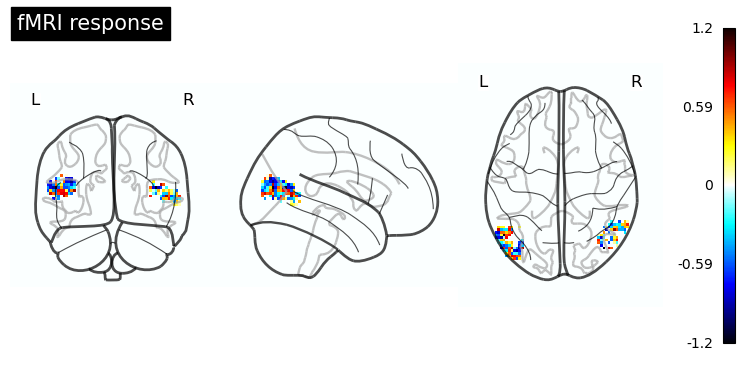

In [57]:
# visualize the masked WB data using the 3d voxel mask

results_dir = find_repo_root()
visual_mask_3D = np.zeros((78, 93, 71))
visual_mask_3D[voxel_mask==1]= ROI_masked_data
brain_mask = './example.nii'
nii_save_path = os.path.join(results_dir, 'vid_activity.nii')
saveasnii(brain_mask, nii_save_path, visual_mask_3D)

# visualizing saved nifti file
plotting.plot_glass_brain(nii_save_path,
                      title='fMRI response',plot_abs=False,
                      display_mode='ortho',colorbar=True)

In [60]:
# test the workaround for the whole dataset

data, voxel_mask = get_fmri(sub, ROI)
print(data.shape)
print(len(np.unique(data[0, :])))
print(voxel_mask.shape)
print(np.sum(voxel_mask == 1))

# see if ROI can be mapped into 3d space using the unique values of the 3d WB data
ROI_data = get_fmri("sub01", "EBA")
print(ROI_data[0,:].shape)
print(len(np.unique(ROI_data[0,:])))
print(data[0, :].shape)
# check number of common elements
print("Number of common elements:",np.sum(np.isin(ROI_data[0,:], data[0, :])))

(1000, 18222)
18222
(78, 93, 71)
18222
(351,)
351
(18222,)
Number of common elements: 351


In [64]:
def check_conditions(subs, ROIs):
    results = []

    for sub in tqdm(subs, desc="Processing subjects"):
        data, voxel_mask = get_fmri(sub, "WB")
        
        for ROI in tqdm(ROIs, desc=f"Processing ROIs for subject {sub}", leave=False):
            if ROI != "WB":           
                ROI_data = get_fmri(sub, ROI)

                for i in range(data.shape[0]):
                    # Check the conditions
                    condition1 = len(np.unique(data[i, :])) == np.sum(voxel_mask == 1)
                    condition2 = ROI_data[i, :].shape[0] == len(np.unique(ROI_data[i, :]))
                    condition3 = len(np.unique(ROI_data[i, :])) == np.sum(np.isin(ROI_data[i, :], data[i, :]))
                    # If any condition is not true, store the information
                    if not all([condition1, condition2, condition3]):
                        results.append({
                            'subject': sub,
                            'ROI': ROI,
                            'row': i,
                            'conditions': {
                                'condition1': condition1,
                                'condition2': condition2,
                                'condition3': condition3
                            }
                        })

    return results

In [65]:
# Example usage
subs = ["sub01", "sub02", "sub03", "sub04", "sub05", "sub06", "sub07", "sub08", "sub09", "sub10"]
ROIs = ["V1", "V2", "V3", "V4", "LOC", "EBA", "FFA", "STS", "PPA", "WB"]
failed_conditions = check_conditions(subs, ROIs)

# Print the results
for failure in failed_conditions:
    print(failure)

Processing subjects: 100%|██████████| 10/10 [02:48<00:00, 16.89s/it]             


In [66]:
print(failed_conditions)
# All the values in the WB and ROI data are unique. The unique values in the ROI data correspond to unique values in WB data.

[]


In [92]:
# ROI and WB data visualization functions
def saveasnii(brain_mask, nii_save_path, nii_data):
  img = nib.load(brain_mask)
  nii_img = nib.Nifti1Image(nii_data, img.affine, img.header)
  nib.save(nii_img, nii_save_path)
  
def visualize_ROI_activity(sub, ROI, vid_id):
    # load WB and ROI data
    data, voxel_mask = get_fmri(sub, "WB")
    ROI_data = get_fmri(sub, ROI)
    
    # Check mapping conditions
    condition1 = len(np.unique(data[vid_id, :])) == np.sum(voxel_mask == 1) # voxel mask corresponds to unique values in WB array
    condition2 = ROI_data[vid_id, :].shape[0] == len(np.unique(ROI_data[vid_id, :])) # ROI array only has unique values (no duplicates)
    condition3 = len(np.unique(ROI_data[vid_id, :])) == np.sum(np.isin(ROI_data[vid_id, :], data[vid_id, :])) # number of common values in ROI and WB array is exactly the number of unique values in ROI array
    if not condition1:
        print("Mapping condition 1 not met: Voxel mask does not correspond to unique values in WB array")
    if not condition2:
        print("Mapping condition 2 not met: ROI array has duplicate values")
    if not condition3:
        print("Mapping condition 3 not met: Number of common values in ROI and WB array does not equal the number of unique values in ROI array")
    
    # create a new array from the WB data that is masked by the ROI data
    ROI_mask = np.isin(data[vid_id, :], ROI_data[vid_id,:])
    ROI_masked_data = np.where(ROI_mask, data[vid_id,:], 0)
    
    # visualize the masked WB data using the 3d voxel mask
    results_dir = find_repo_root()
    visual_mask_3D = np.zeros((78, 93, 71))
    visual_mask_3D[voxel_mask==1]= ROI_masked_data
    brain_mask = './example.nii'
    nii_save_path = os.path.join(results_dir, 'vid_activity.nii')
    saveasnii(brain_mask, nii_save_path, visual_mask_3D)
    
    # visualizing saved nifti file
    plotting.plot_glass_brain(nii_save_path,
                          title=f'fMRI response to video {vid_id+1} in {ROI}',plot_abs=False,
                          display_mode='ortho',colorbar=True)

def visualize_WB_activity(sub, vid_id):
  # Setting up the paths for whole brain data
  fmri_dir = 'participants_data_v2021'
  track = "full_track"

  # get the right track directory depending on whole brain/ROI choice
  track_dir = os.path.join(fmri_dir, track)

  # get the selected subject's directory
  sub_fmri_dir = os.path.join(track_dir, sub)

  # result directory to store nifti file
  results_dir = find_repo_root()

  # mapping the data to voxels and storing in a nifti file
  data, voxel_mask = get_fmri(sub, "WB")
  visual_mask_3D = np.zeros((78, 93, 71))
  visual_mask_3D[voxel_mask==1]= data[vid_id, :]
  brain_mask = './example.nii'
  nii_save_path = os.path.join(results_dir, 'vid_activity.nii')
  saveasnii(brain_mask, nii_save_path, visual_mask_3D)

  # visualizing saved nifti file
  plotting.plot_glass_brain(nii_save_path,
                          title=f'fMRI response to video {vid_id+1} in WB',plot_abs=False,
                          display_mode='ortho',colorbar=True)

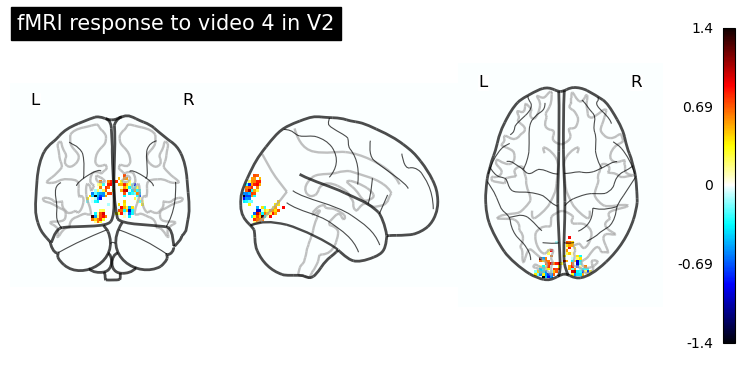

In [79]:
visualize_ROI_activity("sub01", "V2", 3)

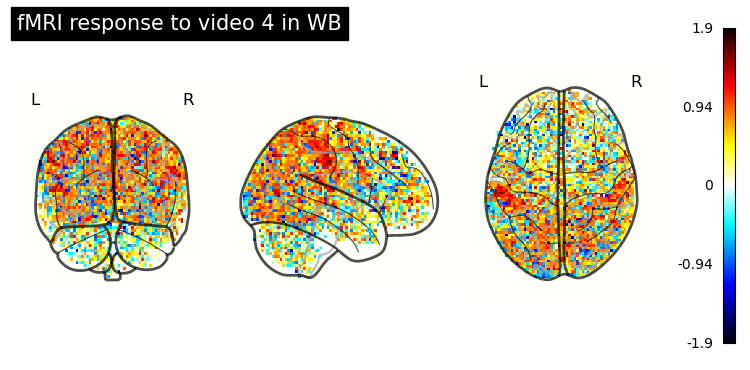

In [93]:
visualize_WB_activity("sub01", 3)

In [ ]:
# Next checks:

# investigate how challengers did it
# investigate if there are preset voxel masks or brain masks for the different ROIs

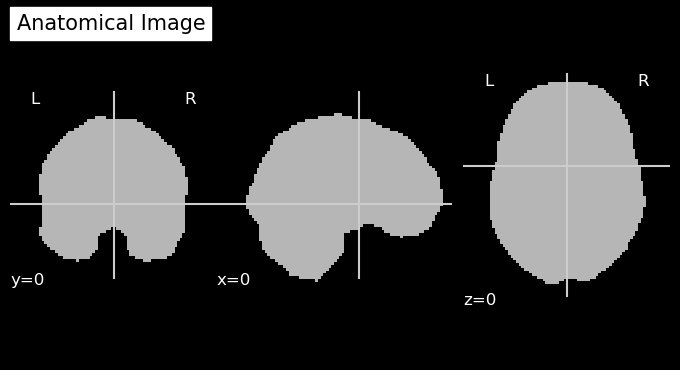

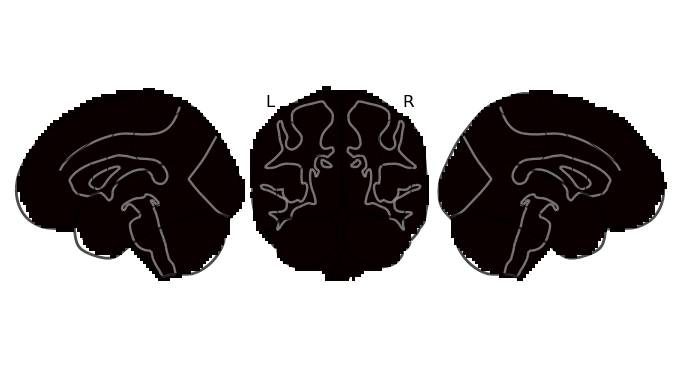

In [54]:
plotting.plot_anat('example.nii', title="Anatomical Image", display_mode='ortho', cut_coords=(0, 0, 0))

plotting.plot_glass_brain('example.nii', display_mode='lyr')

# Display the plot
plotting.show()